This notebook is an explanation of gradients accumulation by custom loop training for TensorFlow 2.0.
Main part is Training term.
Please have a comment if you know better way.

This example uses CIFAR10 dataset. You can use this in NLP model like Transformer, BERT, etc.

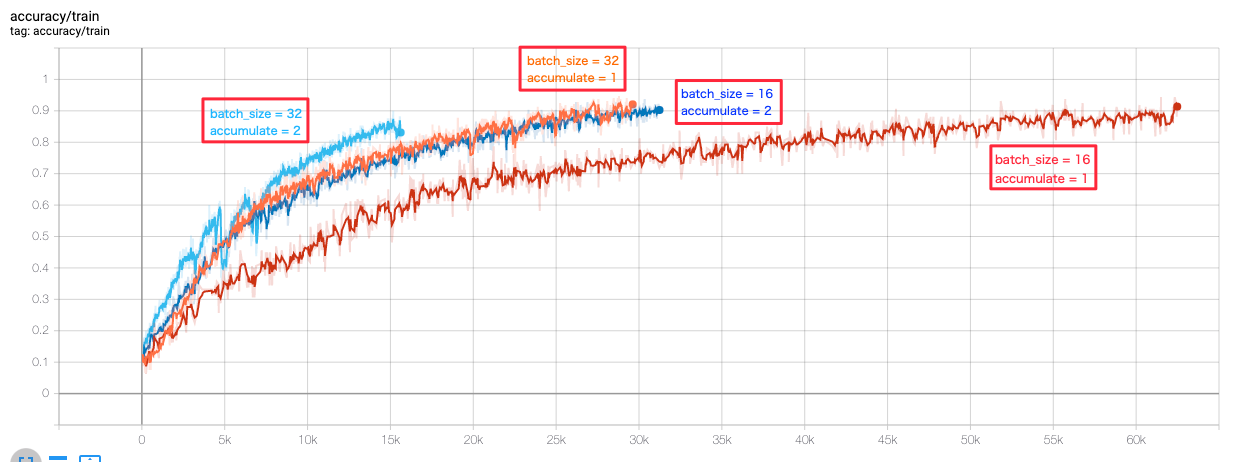

In [ ]:
# basic
import os
import sys
import datetime
from pathlib import Path
import json
from typing import List, Optional, Dict, Generator, NamedTuple, Any, Tuple, Union, Mapping
from enum import Enum
import re

# data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import master_bar, progress_bar

# ml
import tensorflow as tf

In [ ]:
!pip install tensorflow_datasets

In [ ]:
tf.__version__

In [ ]:
devices = tf.config.experimental.list_physical_devices('GPU')
print(devices)
for d in devices:
    tf.config.experimental.set_memory_growth(d, True)

# Config

In [ ]:
class Config:
    model_name = 'resnet50_ga_64'
    num_epochs = 1  # for commit, original = 20
    batch_size = 32
    learning_rate = 1e-2
    num_grad_accumulates = 2
    image_size = 32
    step_summary_output = 10

config = Config()

# Dataloader

In [ ]:
def transform(x, y):
    return tf.cast(x, tf.float32) / 255.0, y

In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load(name='cifar10', split=tfds.Split.TRAIN, with_info=True, as_supervised=True)
dataset = dataset.map(transform)
dataset = dataset.shuffle(1024).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
info

# Model

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
class Model(tf.keras.Model):
    def __init__(self, num_outputs: int) -> None:
        super().__init__()
        self.num_outputs = num_outputs
        
    def build(self, input_shape) -> None:
        self.core = ResNet50(
            include_top=False,
            weights='imagenet',
            input_tensor=None,
            input_shape=None,
            pooling='max',
            classes=10,
        )
        self.output_layer = tf.keras.layers.Dense(self.num_outputs)
        super().build(input_shape)
    
    def call(self, x: tf.Tensor, training: bool = False) -> tf.Tensor:
        y = self.core(x)
        y = self.output_layer(y)
        return y

In [ ]:
model = Model(num_outputs=10)
# build
input_shape = (config.image_size, config.image_size, 3)
input = tf.keras.layers.Input(shape=input_shape, name='input_layer', dtype=tf.float32)
_ = model(input)
model.summary()

# Training

The `accumulated_gradients` method is the one that average gradients in some batches.

In the case of NLP model, we use tf.gather method in the embedding layer.
Because gradient of operation tf.gather turn to type tf.IndexSlices, we have to convert it to tf.Tensor in order to get average gradients.
`flat_gradient` is the method to convert.

In [ ]:
def accumulated_gradients(gradients: Optional[List[tf.Tensor]],
                          step_gradients: List[Union[tf.Tensor, tf.IndexedSlices]],
                          num_grad_accumulates: int) -> tf.Tensor:
    if gradients is None:
        gradients = [flat_gradients(g) / num_grad_accumulates for g in step_gradients]
    else:
        for i, g in enumerate(step_gradients):
            gradients[i] += flat_gradients(g) / num_grad_accumulates
        
    return gradients

# This is needed for tf.gather like operations.
def flat_gradients(grads_or_idx_slices: tf.Tensor) -> tf.Tensor:
    '''Convert gradients if it's tf.IndexedSlices.
    When computing gradients for operation concerning `tf.gather`, the type of gradients 
    '''
    if type(grads_or_idx_slices) == tf.IndexedSlices:
        return tf.scatter_nd(
            tf.expand_dims(grads_or_idx_slices.indices, 1),
            grads_or_idx_slices.values,
            grads_or_idx_slices.dense_shape
        )
    return grads_or_idx_slices

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                        reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Adam(config.learning_rate)
train_loss = tf.keras.metrics.Mean('loss/train', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('accuracy/train')
metrics = [train_loss, train_accuracy]

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = f'logs/{config.model_name}/{current_time}'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)


def train(config: Config,
          dataset: tf.data.Dataset,
          model: Model):
    global_step = 0
    for e in range(config.num_epochs):
        global_step = train_epoch(config, dataset, model, global_step)
        print(f'{e+1} epoch finished. step: {global_step}')


def train_epoch(config: Config,
                dataset: tf.data.Dataset,
                model: Model,
                start_step: int = 0) -> tf.Tensor:
    '''Train 1 epoch
    '''
    gradients = None
    global_step = start_step
    for i, batch in enumerate(dataset):
        dummy_step = i + start_step * config.num_grad_accumulates
        x_train, y_train = batch
        step_gradients = train_step(x_train, y_train, loss_fn, optimizer)
        gradients = accumulated_gradients(gradients, step_gradients, config.num_grad_accumulates)
        if (dummy_step + 1) % config.num_grad_accumulates == 0:
            gradient_zip = zip(gradients, model.trainable_variables)
            optimizer.apply_gradients(gradient_zip)
            gradients = None
            if (global_step + 1) % config.step_summary_output == 0:
                write_train_summary(train_summary_writer, metrics, step=global_step + 1)
            global_step += 1

    return global_step


@tf.function
def train_step(x_train: tf.Tensor,
               y_train: tf.Tensor,
               loss_fn: tf.keras.losses.Loss,
               optimizer: tf.keras.optimizers.Optimizer):
    '''Train 1 step and return gradients
    '''
    with tf.GradientTape() as tape:
        outputs = model(x_train, training=True)
        loss = tf.reduce_mean(loss_fn(y_train, outputs))
    train_loss(loss)
    train_accuracy(y_train, tf.nn.softmax(outputs))
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients


def write_train_summary(writer: tf.summary.SummaryWriter,
                        metrics: List[tf.keras.metrics.Metric],
                        step: int) -> None:
    with writer.as_default():
        for metric in metrics:
            tf.summary.scalar(metric.name, metric.result(), step=step)
            metric.reset_states()
            

In [ ]:
%%time
train(config, dataset, model)